In [ ]:
import pandas as pd

# Step 1: Load the data
file_path = '/Users/seyed/Git/Hub/Learning-Style-Questionnaire/Raw_Data.csv'
df = pd.read_csv(file_path)

# Step 2: Show basic info
print("Shape of dataset:", df.shape)
print("\nColumns:", df.columns.tolist())

# Step 3: Check for missing or empty values
missing_values = df.isnull().sum()
print("\nMissing values per column:\n", missing_values)


Shape of dataset: (58, 21)

Columns: ['ID', 'Start time', 'Completion time', 'Email', 'Name', 'Last modified time', 'Age?', 'Gender?', 'Year of study?', 'From the scale of 1 to 10 how familiar are you with the concept of learning styles?', 'Which learning style best describes you?', 'How many hours do you use visual learning aids (e.g. diagram, charts ,videos)?', 'How many hours do you spend on audio-based learning ( Lectures, podcasts, discussions)?', 'How many hours do you spend on hands-on or practical learning ( experiments, \xa0case studies)?', 'How many hours do you study using written materials (Books, articles, notes)?', 'From the scale of 1 to 10 how much LSBU teaching methods support your learning style?', 'Which LSBU learning method do you find most effective?', "How often do you use LSBU's digital learning resources (Moodle, recorded lectures, online library)?", "How effective do you find LSBU's current teaching methods?", 'What is your average assessment results(%)?', 'Fro

In [3]:
# Step 4: Drop unnecessary columns
columns_to_drop = ['Email', 'Name', 'Last modified time']
df_cleaned = df.drop(columns=columns_to_drop)

# Save the cleaned version 
df_cleaned.to_csv('/Users/seyed/Git/Hub/Learning-Style-Questionnaire/Cleaned_Data.csv', index=False)

In [5]:
# Step 5: Check for exact duplicate rows
duplicate_rows = df_cleaned[df_cleaned.duplicated()]
print("Duplicate rows:")
print(duplicate_rows)


Duplicate rows:
Empty DataFrame
Columns: [ID, Start time, Completion time, Age?, Gender?, Year of study?, From the scale of 1 to 10 how familiar are you with the concept of learning styles?, Which learning style best describes you?, How many hours do you use visual learning aids (e.g. diagram, charts ,videos)?, How many hours do you spend on audio-based learning ( Lectures, podcasts, discussions)?, How many hours do you spend on hands-on or practical learning ( experiments,  case studies)?, How many hours do you study using written materials (Books, articles, notes)?, From the scale of 1 to 10 how much LSBU teaching methods support your learning style?, Which LSBU learning method do you find most effective?, How often do you use LSBU's digital learning resources (Moodle, recorded lectures, online library)?, How effective do you find LSBU's current teaching methods?, What is your average assessment results(%)?, From the scale of 1 to 10 how much do you believe  that LSBU have necessary 

In [ ]:
import pandas as pd


# 1. Rename columns to shorter names
rename_map = {
    'ID': 'ID',
    'Start time': 'Start',
    'Completion time': 'End',
    'Age?': 'Age',
    'Gender?': 'Gender',
    'Year of study?': 'Year',
    'From the scale of 1 to 10 how familiar are you with the concept of learning styles?': 'Familiarity',
    'Which learning style best describes you?': 'PrefStyle',
    'How many hours do you use visual learning aids (e.g. diagram, charts ,videos)?': 'VisualHrs',
    'How many hours do you spend on audio-based learning ( Lectures, podcasts, discussions)?': 'AudioHrs',
    'How many hours do you spend on hands-on or practical learning ( experiments,  case studies)?': 'PracticalHrs',
    'How many hours do you study using written materials (Books, articles, notes)?': 'WrittenHrs',
    'From the scale of 1 to 10 how much LSBU teaching methods support your learning style?': 'SupportRating',
    'Which LSBU learning method do you find most effective?': 'BestMethod',
    "How often do you use LSBU's digital learning resources (Moodle, recorded lectures, online library)?": 'DigitalFreq',
    "How effective do you find LSBU's current teaching methods?": 'MethodEffectiveness',
    'What is your average assessment results(%)?': 'AssessmentCat',
    'From the scale of 1 to 10 how much do you believe  that LSBU have necessary resources matching your learning style? ': 'ResourceRating'
}
df_prep = df_cleaned.rename(columns=rename_map)

# 2. Convert Start/End to elapsed minutes
df_prep['Start'] = pd.to_datetime(df_prep['Start'])
df_prep['End']   = pd.to_datetime(df_prep['End'])
df_prep['ElapsedMins'] = (df_prep['End'] - df_prep['Start']).dt.total_seconds() / 60

# 3. Convert Year of study to numeric
year_map = {
    'First year':  1,
    'Second year': 2,
    'Third year':  3
    }
df_prep['YearNum'] = df_prep['Year'].map(year_map)


# 4. Cast numeric columns
num_cols = ['Age', 'YearNum', 'Familiarity', 'VisualHrs', 'AudioHrs', 'PracticalHrs',
             'WrittenHrs', 'SupportRating', 'DigitalFreq', 'MethodEffectiveness', 'ResourceRating']
df_prep[num_cols] = df_prep[num_cols].apply(pd.to_numeric, errors='coerce')

# 5. Mapping style from long text to short category
pref_map = {
    'Reading/ Writing ( Text-based learning)': 'Reading',
    'Mix of styles':                       'Mixed',
    'Visual (Images, charts)':             'Visual',
    'Auditory ( Listening, discussions)':  'Auditory',
    'Kinesthetic ( Hands-on activities)':  'Kinesthetic'
}
df_prep['PrefStyleShort'] = df_prep['PrefStyle'].map(pref_map)

# 6. Recode AssessmentCat into ordered categories or numeric mid-points
#    For example, map to midpoint values:
mapping = {
    'less than 40': 20,
    '41 to 60':     50,
    '60 to 70':     65,
    'Above 70':     85
}
df_prep['AssessmentScore'] = df_prep['AssessmentCat'].map(mapping)

# 7. Create new features
df_prep['TotalStudyHrs'] = df_prep[['VisualHrs','AudioHrs','PracticalHrs','WrittenHrs']].sum(axis=1)

# Check modal alignment—for each row the max‐hours mode vs. PrefStyle
def dominant_mode(row):
    modes = {
        'Visual': row['VisualHrs'],
        'Auditory': row['AudioHrs'],
        'Practical': row['PracticalHrs'],
        'Written': row['WrittenHrs']
    }
    return max(modes, key=modes.get)

df_prep['DominantMode'] = df_prep.apply(dominant_mode, axis=1)
df_prep['ModeMatchesPreference'] = (df_prep['DominantMode'] == df_prep['PrefStyleShort'])

# 8. Drop redundant columns
# List of columns to remove now that they're redundant
to_drop = [
    'PrefStyle',
    'AssessmentCat',
    'Start',
    'End',
    'Year'
]
# Drop them
df_prep = df_prep.drop(columns=to_drop)


# 9. Save to new CSV (this will become your “Sheet 2” Pre-processed Data)
df_prep.to_csv('/Users/seyed/Git/Hub/Learning-Style-Questionnaire/Preprocessed_Data.csv', index=False)

# 10. Quick check
print("Final shape:", df_prep.shape)
print("Any missing in numeric cols?\n", df_prep[num_cols + ['AssessmentScore']].isnull().sum())
print("Mode vs Pref count:\n", df_prep['ModeMatchesPreference'].value_counts())


Final shape: (58, 20)
Any missing in numeric cols?
 Age                    0
YearNum                0
Familiarity            0
VisualHrs              0
AudioHrs               0
PracticalHrs           0
WrittenHrs             0
SupportRating          0
DigitalFreq            0
MethodEffectiveness    0
ResourceRating         0
AssessmentScore        0
dtype: int64
Mode vs Pref count:
 ModeMatchesPreference
False    45
True     13
Name: count, dtype: int64


/var/folders/t4/cdl5lz8x3_q57skg4gy3h0840000gn/T/ipykernel_5039/3285605965.py:28: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_prep['Start'] = pd.to_datetime(df_prep['Start'])
/var/folders/t4/cdl5lz8x3_q57skg4gy3h0840000gn/T/ipykernel_5039/3285605965.py:29: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_prep['End']   = pd.to_datetime(df_prep['End'])


In [19]:
print(df_prep.info())
print(df_prep.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58 entries, 0 to 57
Data columns (total 20 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   ID                     58 non-null     int64  
 1   Age                    58 non-null     int64  
 2   Gender                 58 non-null     object 
 3   Familiarity            58 non-null     int64  
 4   VisualHrs              58 non-null     int64  
 5   AudioHrs               58 non-null     int64  
 6   PracticalHrs           58 non-null     int64  
 7   WrittenHrs             58 non-null     int64  
 8   SupportRating          58 non-null     int64  
 9   BestMethod             58 non-null     object 
 10  DigitalFreq            58 non-null     int64  
 11  MethodEffectiveness    58 non-null     int64  
 12  ResourceRating         58 non-null     int64  
 13  ElapsedMins            58 non-null     float64
 14  YearNum                58 non-null     int64  
 15  PrefStyl

In [20]:
# Filter to the “False” cases
false_df = df_prep[df_prep['ModeMatchesPreference'] == False]

# Compute the stats
mean_elapsed = false_df['ElapsedMins'].mean()
min_elapsed  = false_df['ElapsedMins'].min()
max_elapsed  = false_df['ElapsedMins'].max()

print(f"Elapsed time when ModeMatchesPreference is False:")
print(f"  Mean: {mean_elapsed:.1f} minutes")
print(f"  Min : {min_elapsed:.1f} minutes")
print(f"  Max : {max_elapsed:.1f} minutes")


Elapsed time when ModeMatchesPreference is False:
  Mean: 5.6 minutes
  Min : 0.1 minutes
  Max : 137.1 minutes


In [ ]:
from pandas import read_csv
df_prep = read_csv('/Users/seyed/Git/Hub/Learning-Style-Questionnaire/Preprocessed_Data.csv')


In [5]:
OneMin_percentile = (df_prep['ElapsedMins'] < 1).mean() * 100
print(f"Percentage of respondents who completed the survey in less than 1 minute: {OneMin_percentile:.2f}%")

Percentage of respondents who completed the survey in less than 1 minute: 34.48%


In [ ]:
import pandas as pd

# Load your preprocessed data
df = pd.read_csv('/Users/seyed/Git/Hub/Learning-Style-Questionnaire/Preprocessed_Data.csv')

# Select the numeric columns you care about
numeric_cols = [
    'Age', 'YearNum', 'Familiarity', 
    'VisualHrs', 'AudioHrs', 'PracticalHrs', 'WrittenHrs',
    'SupportRating', 'MethodEffectiveness', 'DigitalFreq',
    'ResourceRating', 'AssessmentScore', 'TotalStudyHrs', 'ElapsedMins'
]

# 1. Summary via describe()
desc = df[numeric_cols].describe().T
print("=== Describe (count, mean, std, min, quartiles, max) ===")
print(desc)

# 2. Compute mode for each column
modes = df[numeric_cols].mode().iloc[0]
print("\n=== Mode ===")
print(modes)

# 3. Compute variance for each column
variances = df[numeric_cols].var()
print("\n=== Variance ===")
print(variances)

# 4. Count of non-null and nulls
null_counts = df[numeric_cols].isnull().sum()
print("\n=== Missing Values ===")
print(null_counts)


=== Describe (count, mean, std, min, quartiles, max) ===
                     count       mean        std    min    25%     50%  \
Age                   58.0  20.103448   2.057845  18.00  19.00  20.000   
YearNum               58.0   1.051724   0.291542   1.00   1.00   1.000   
Familiarity           58.0   6.206897   1.997882   2.00   5.00   6.000   
VisualHrs             58.0   8.637931   9.168402   0.00   2.00   5.000   
AudioHrs              58.0   7.879310   8.085242   0.00   2.00   5.000   
PracticalHrs          58.0   7.844828   7.940131   0.00   2.00   4.500   
WrittenHrs            58.0   7.275862   8.151618   0.00   2.00   5.000   
SupportRating         58.0   6.396552   1.716173   1.00   5.00   7.000   
MethodEffectiveness   58.0   6.500000   1.635677   2.00   5.25   6.000   
DigitalFreq           58.0   6.379310   1.765434   3.00   5.00   6.000   
ResourceRating        58.0   6.275862   1.683700   1.00   5.00   6.000   
AssessmentScore       58.0  67.413793  18.946864  20.00

In [ ]:
# 1. Frequency distributions (value counts & percentages)
for col in ['PrefStyleShort', 'YearNum', 'ModeMatchesPreference']:
    counts = df[col].value_counts(dropna=False)
    pct    = df[col].value_counts(normalize=True, dropna=False) * 100
    print(f"\n--- {col} Value Counts ---")
    print(pd.concat([counts, pct.round(1)], axis=1).rename(columns={col: 'Count', col: 'Percent'}))

# 2. Pivot table: average assessment by style
pivot_style = df.pivot_table(
    index='PrefStyleShort',
    values='AssessmentScore',
    aggfunc=['count', 'mean', 'std']
)
pivot_style.columns = ['N', 'MeanScore', 'StdDevScore']
print("\n--- Assessment Score by Preferred Style ---")
print(pivot_style)

# 3. Pivot table: mean TotalStudyHrs by Year and by ModeMatchesPreference
pivot_year_mode = df.pivot_table(
    index='YearNum',
    columns='ModeMatchesPreference',
    values='TotalStudyHrs',
    aggfunc=['mean', 'count']
)
print("\n--- Total Study Hours by Year & Match Status ---")
print(pivot_year_mode)

# 4. Crosstab: PrefStyleShort vs. ModeMatchesPreference
ct = pd.crosstab(df['PrefStyleShort'], df['ModeMatchesPreference'], margins=True)
print("\n--- Preference vs. Match Crosstab ---")
print(ct)

# 5. Distribution checks: boxplot stats (min, Q1, median, Q3, max)
def box_stats(series):
    q1 = series.quantile(0.25)
    q2 = series.quantile(0.50)
    q3 = series.quantile(0.75)
    return {
        'min': series.min(),
        'Q1':  q1,
        'median': q2,
        'Q3':  q3,
        'max': series.max()
    }

for col in ['VisualHrs', 'AudioHrs', 'PracticalHrs', 'WrittenHrs', 'TotalStudyHrs']:
    stats = box_stats(df[col])
    print(f"\n--- Box stats for {col} ---")
    print(stats)

# 6. Correlation matrix (Pearson’s r)
corr = df[['Familiarity', 'SupportRating', 'MethodEffectiveness', 
           'DigitalFreq', 'TotalStudyHrs', 'AssessmentScore']].corr()
print("\n--- Correlation Matrix ---")
print(corr.round(2))

# 7. Grouped summary: average MethodEffectiveness by digital-use tertiles
df['DigitalTertile'] = pd.qcut(df['DigitalFreq'], q=3, labels=['Low', 'Med', 'High'])
grouped = df.groupby('DigitalTertile')['MethodEffectiveness'].agg(['count', 'mean', 'std'])
print("\n--- MethodEffectiveness by Digital-Use Tertile ---")
print(grouped)



--- PrefStyleShort Value Counts ---
                count  proportion
PrefStyleShort                   
Visual             25        43.1
Reading            10        17.2
Mixed              10        17.2
Auditory            8        13.8
Kinesthetic         5         8.6

--- YearNum Value Counts ---
         count  proportion
YearNum                   
1           56        96.6
3            1         1.7
2            1         1.7

--- DigitalFreq Value Counts ---
             count  proportion
DigitalFreq                   
5               14        24.1
7               13        22.4
6                9        15.5
8                8        13.8
9                4         6.9
4                4         6.9
10               3         5.2
3                3         5.2

--- Assessment Score by Preferred Style ---
                 N  MeanScore  StdDevScore
PrefStyleShort                            
Auditory         8     78.125    13.346348
Kinesthetic      5     81.000     8.944272

/var/folders/t4/cdl5lz8x3_q57skg4gy3h0840000gn/T/ipykernel_8895/1401036846.py:59: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df.groupby('DigitalTertile')['MethodEffectiveness'].agg(['count', 'mean', 'std'])


/var/folders/t4/cdl5lz8x3_q57skg4gy3h0840000gn/T/ipykernel_8895/4000905068.py:7: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data_to_plot, labels=cols_to_plot)


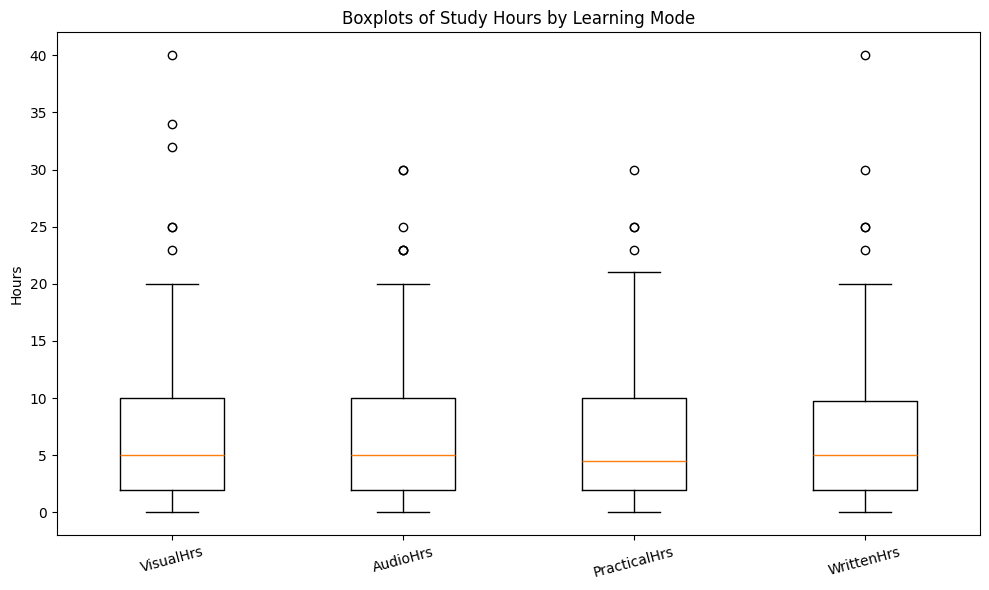

In [12]:
import matplotlib.pyplot as plt

cols_to_plot = ['VisualHrs', 'AudioHrs', 'PracticalHrs', 'WrittenHrs']
data_to_plot = [df[col].dropna() for col in cols_to_plot]

plt.figure(figsize=(10, 6))
plt.boxplot(data_to_plot, labels=cols_to_plot)
plt.title('Boxplots of Study Hours by Learning Mode')
plt.ylabel('Hours')
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()


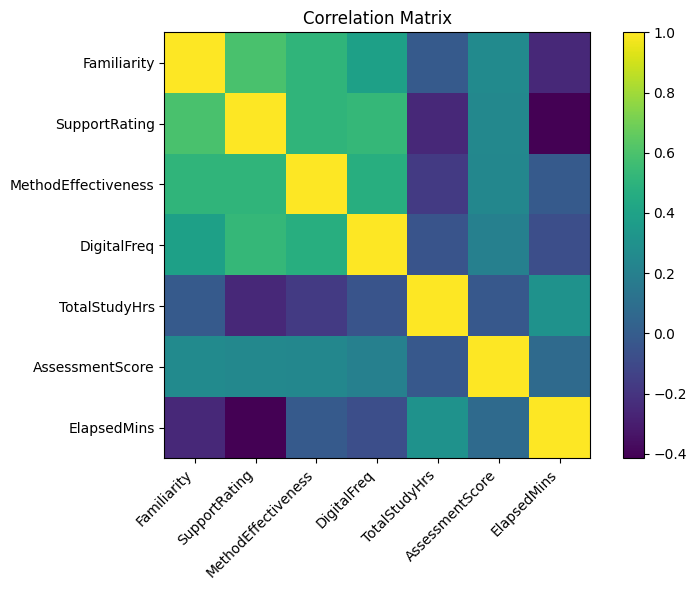

In [14]:
cols = ['Familiarity', 'SupportRating', 'MethodEffectiveness', 
        'DigitalFreq', 'TotalStudyHrs', 'AssessmentScore', 'ElapsedMins']
corr_matrix = df[cols].corr()

plt.figure(figsize=(8, 6))
plt.imshow(corr_matrix, aspect='equal', interpolation='nearest')
plt.colorbar()
plt.title('Correlation Matrix')
plt.xticks(range(len(cols)), cols, rotation=45, ha='right')
plt.yticks(range(len(cols)), cols)
plt.tight_layout()
plt.show()

In [15]:
corr = df[['Familiarity', 'SupportRating', 'MethodEffectiveness', 
           'DigitalFreq', 'TotalStudyHrs', 'AssessmentScore']].corr()
print("\n--- Correlation Matrix ---")
print(corr.round(2))



--- Correlation Matrix ---
                     Familiarity  SupportRating  MethodEffectiveness  \
Familiarity                 1.00           0.59                 0.51   
SupportRating               0.59           1.00                 0.51   
MethodEffectiveness         0.51           0.51                 1.00   
DigitalFreq                 0.39           0.53                 0.47   
TotalStudyHrs              -0.01          -0.25                -0.17   
AssessmentScore             0.26           0.25                 0.24   

                     DigitalFreq  TotalStudyHrs  AssessmentScore  
Familiarity                 0.39          -0.01             0.26  
SupportRating               0.53          -0.25             0.25  
MethodEffectiveness         0.47          -0.17             0.24  
DigitalFreq                 1.00          -0.04             0.20  
TotalStudyHrs              -0.04           1.00            -0.03  
AssessmentScore             0.20          -0.03             1.00 

In [17]:
from scipy.stats import pearsonr

# 1. Filter to matched students
matched = df[df['ModeMatchesPreference'] == True]

# 2. Extract the two series
x = matched['TotalStudyHrs']
y = matched['AssessmentScore']

# 3. Compute Pearson correlation and p-value
r, p = pearsonr(x, y)

print(f"Number of matched students: {len(matched)}")
print(f"Pearson’s r = {r:.2f}")
print(f"p-value     = {p:.3f}")

Number of matched students: 13
Pearson’s r = -0.17
p-value     = 0.589
